In [1]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from torchvision import models
from torchvision import transforms
from torchvision.io import read_image

from torchmetrics.functional import f1_score, accuracy

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

import random
import os, sys
from os.path import join as join_path

In [2]:
NAME_MODEL = 'ResNet18'
TEST_SIZE = .3
BATCH_SIZE = 200


RANDOM_SEAD = 42

DATA_PATH = 'data'
TEMPORARY_PATH = 'temporary'
IMG_PATH = join_path(DATA_PATH, 'img')

In [3]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
df = pd.read_csv(join_path(DATA_PATH, 'labels.csv'))
print(df)
print(df.label.sum(), '/', len(df), '=', df.label.sum()/len(df))

                                                  token  label
0     959cf47bf2fdb487e59f3f86bd816f22a25380198e08f7...      0
1     dc0222a2de2581157b88a2a8d08d04b3860e9598f8e6a2...      0
2     cabfd08de898dda64dfcea939ea306f8df3de11daf32f5...      0
3     96d7173a6ca06f75f1c40be76ee4b885a8b08af642632d...      0
4     34bb413abe5e84be32c400915894b46ce8244b8d26e34a...      0
...                                                 ...    ...
2498  3dfac51caf3dbec992571c913d46dabed90ad018dfa604...      0
2499  46020d3e85b9e4c065ffc0e58b73a7f7c2c7297466df9a...      0
2500  c86db1aa6b06e2e4c84fc0f1d582e50f42188af42ae090...      1
2501  cb9ffa11f53565e4808d9c4f7540f77464cc42bd824434...      1
2502  b1b1d054cbbd54e3e6a224560c6b235c98302a837ab4b5...      1

[2503 rows x 2 columns]
466 / 2503 = 0.18617658809428686


In [6]:
class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df

        self.device = device
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if idx >= len(self): raise StopIteration
        token, sign = self.df.loc[idx, ['token', 'label']]

        img = read_image(join_path(IMG_PATH, f'{token}.jpg'))
        if self.transform:
            img = self.transform(img)

        return img, sign


In [7]:
df_train, df_val = train_test_split(df, test_size=TEST_SIZE)
df_train, df_val = df_train.reset_index(drop=True), df_val.reset_index(drop=True)

In [8]:
transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation((-10, 10)),

    transforms.RandomCrop(119),

    transforms.RandomHorizontalFlip(),


    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

transform_val = transforms.Compose([
    transforms.ToPILImage(),
    transforms.CenterCrop(119),

    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])


ds_train, ds_val = CustomDataset(df_train, transform_train), CustomDataset(df_val, transform_train)


dl_train, dl_val = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True), DataLoader(ds_val, batch_size=BATCH_SIZE)

In [9]:
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Sequential(nn.Linear(model.fc.in_features, 1), nn.Sigmoid())
model.to(device)

weight = torch.tensor([df_train.label.sum() / len(df_train)])
criterion = nn.BCELoss(weight=weight, reduction='mean')
criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [10]:
def train(epochs,
          model, criterion, optimizer,
          dl_train, dl_val,
          log=None):

    log = log if log is None else {}
    log['loss'] = {'train': [], 'val': []}
    log['accuracy'] = {'train': [], 'val': []}
    log['f1'] = {'train': [], 'val': []}
    log['bestEpoch'] = 0

    for epoch in range(epochs):
        # Train
        model.train()
        running_loss, running_accuracy , running_f1 = 0, 0, 0

        for X, y in dl_train:
            X, y = X.to(device), y.to(device).unsqueeze(1).to(torch.float32)

            optimizer.zero_grad()
            predict = model(X)

            loss = criterion(predict, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_accuracy += accuracy(predict>.5, y>.5).item()
            running_f1 += f1_score(predict>.5, y>.5).item()

        log['loss']['train'].append(running_loss/len(dl_train))
        log['accuracy']['train'].append(running_accuracy/len(dl_train))
        log['f1']['train'].append(running_f1/len(dl_train))


        # Val
        model.eval()
        running_loss, running_accuracy , running_f1 = 0, 0, 0

        for X, y in dl_val:
            X, y = X.to(device), y.to(device).unsqueeze(1).to(torch.float32)

            predict = model(X)

            loss = criterion(predict, y)

            running_loss += loss.item()
            running_accuracy += accuracy(predict>.5, y>.5).item()
            running_f1 += f1_score(predict>.5, y>.5).item()

        log['loss']['val'].append(running_loss/len(dl_val))
        log['accuracy']['val'].append(running_accuracy/len(dl_val))
        log['f1']['val'].append(running_f1/len(dl_val))


        if not log['bestEpoch'] or log['f1']['val'][-1] > max(log['f1']['val'][:-1]):
            torch.save(model.state_dict(), join_path(TEMPORARY_PATH, f'{NAME_MODEL}.pt'))
            log['bestEpoch'] = epoch

        print(f"Epoch: {epoch} / {epochs} | "
              f"\n\t\tloss -> train: {log['loss']['train'][-1]} | val: {log['loss']['val'][-1]}"
              f"\n\t\taccuracy -> train: {log['accuracy']['train'][-1]} | val: {log['accuracy']['val'][-1]}"
              f"\n\t\tf1 -> train: {log['f1']['train'][-1]} | val: {log['f1']['val'][-1]}"
              )

    return log

In [11]:
%%time

log = {}

log = train(50, model, criterion, optimizer,
            dl_train, dl_val, log)

Epoch: 0 / 50 | 
		loss -> train: 0.0886370941168732 | val: 0.05560745671391487
		accuracy -> train: 0.7873976627985636 | val: 0.9305711984634399
		f1 -> train: 0.7873976627985636 | val: 0.9305711984634399
Epoch: 1 / 50 | 
		loss -> train: 0.04378106569250425 | val: 0.043821665458381176
		accuracy -> train: 0.9237426916758219 | val: 0.9230712056159973
		f1 -> train: 0.9237426916758219 | val: 0.9230712056159973
Epoch: 2 / 50 | 
		loss -> train: 0.0442257204817401 | val: 0.03101448155939579
		accuracy -> train: 0.9418128596411811 | val: 0.9513162225484848
		f1 -> train: 0.9418128596411811 | val: 0.9513162225484848
Epoch: 3 / 50 | 
		loss -> train: 0.031583394648300275 | val: 0.02994688181206584
		accuracy -> train: 0.9445613953802321 | val: 0.9484105855226517
		f1 -> train: 0.9445613953802321 | val: 0.9484105855226517
Epoch: 4 / 50 | 
		loss -> train: 0.02765220341583093 | val: 0.028893062844872475
		accuracy -> train: 0.9509941538174947 | val: 0.9508774727582932
		f1 -> train: 0.9509941

In [12]:
print(f"model name: {NAME_MODEL}")
print(f"model total params: {sum(p.numel() for p in model.parameters())}")

model name: ResNet18
model total params: 11177025


In [13]:
print('best epoch:', log['bestEpoch'])
print(f'best loss -> train: {log["loss"]["train"][log["bestEpoch"]]} || val: {log["loss"]["val"][log["bestEpoch"]]}')
print(f'best accuracy -> train: {log["accuracy"]["train"][log["bestEpoch"]]} || val: {log["accuracy"]["val"][log["bestEpoch"]]}')
print(f'best F1 -> train: {log["f1"]["train"][log["bestEpoch"]]} || val: {log["f1"]["val"][log["bestEpoch"]]}')
print(f'best model -> {join_path(TEMPORARY_PATH, f"{NAME_MODEL}.pt")}')

best epoch: 29
best loss -> train: 0.01325668084124724 || val: 0.010502158896997571
best accuracy -> train: 0.9752339323361715 || val: 0.9825000017881393
best F1 -> train: 0.9752339323361715 || val: 0.9825000017881393
best model -> temporary/ResNet18.pt


loss


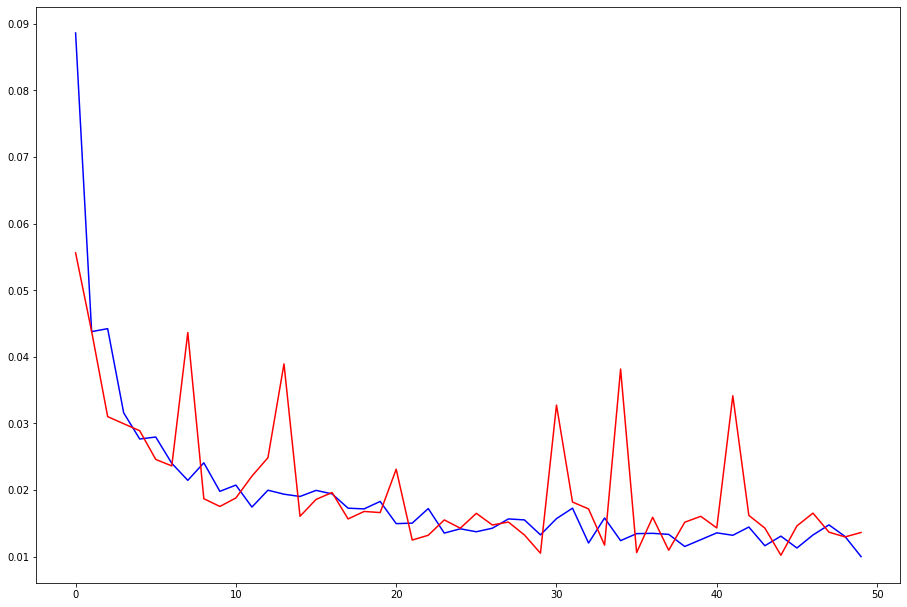

In [14]:
print('loss')
fig = plt.figure()
axes = fig.add_axes([1, 1, 2, 2])

axes.plot(range(len(log['loss']['train'])), log['loss']['train'], 'b')
axes.plot(range(len(log['loss']['val'])), log['loss']['val'], 'r')
plt.show()

accuracy


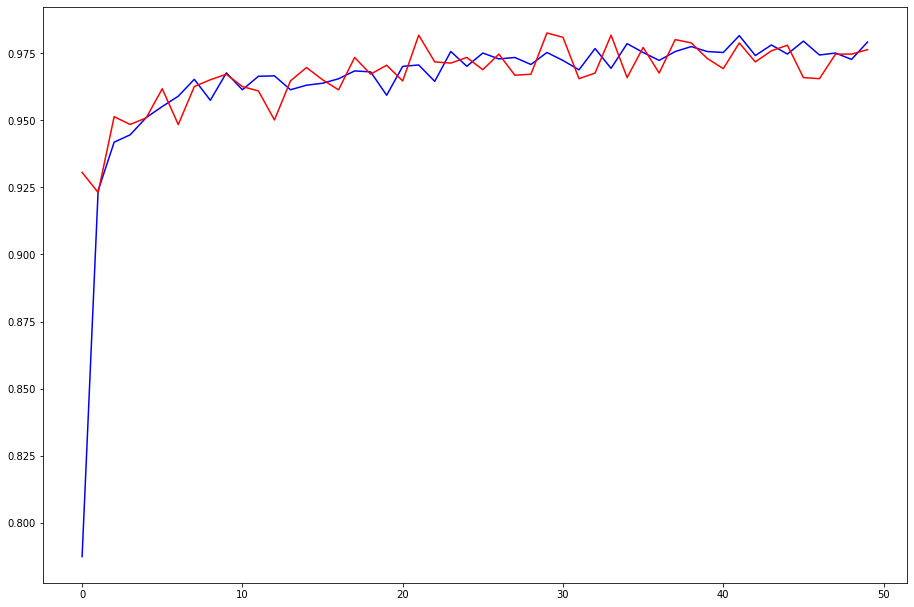

In [15]:
print('accuracy')
fig = plt.figure()
axes = fig.add_axes([1, 1, 2, 2])

axes.plot(range(len(log['accuracy']['train'])), log['accuracy']['train'], 'b')
axes.plot(range(len(log['accuracy']['val'])), log['accuracy']['val'], 'r')
plt.show()

f1


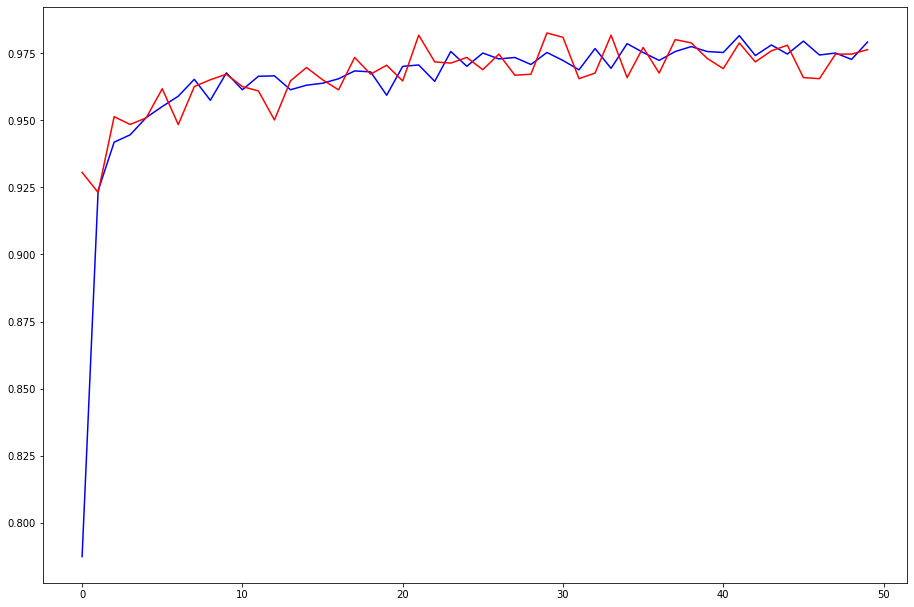

In [16]:
print('f1')
fig = plt.figure()
axes = fig.add_axes([1, 1, 2, 2])

axes.plot(range(len(log['f1']['train'])), log['f1']['train'], 'b')
axes.plot(range(len(log['f1']['val'])), log['f1']['val'], 'r')
plt.show()